In [1]:
%%javascript
IPython.load_extensions("calico-spell-check");

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import matplotlib
matplotlib.use(u'Agg')
import numpy as np
from pylab import rcParams
import matplotlib.pyplot as plt
matplotlib.style.use(u'fivethirtyeight')

In [3]:
from IPython.display import Image, HTML, display
def inline_figure_on_remote(plt, filename='tmp.png', auto_close=True):
    plt.savefig(filename)
    if auto_close:
        plt.close()
    return Image(filename=filename, width=400) 

#meet.ml #1 Practical machine learning in Python

#Agenda

###1. Hello world - Descriptive Statistics, Data Munging & Classification
###2. Data acquistion - Pulling data from the web
###3. Deep learning for computer vision - motivating example
###4. Transfer learning - motivating example
###5. Transfer learning on our dataset, similar image search
###6. NLP for the lazy - word embeddings (word2vec)

#Key libraries:
###    graphlab-create (Dato)
###    newspaper + NLTK,
###    gensim,
###   spacy
###    NearPy

##1. Hello world - Descriptive Statistics, Data Munging & Classification

Our adventure begins with your boss dropping you this email:

*"Hey, we just finished a content analysis project with our BI team and we have this cool new [dataset](http://archive.ics.uci.edu/ml/machine-learning-databases/00332/OnlineNewsPopularity.zip) with loads of data about each article. We also have the number of shares for each article. I was hoping you could use this data to predict how many shares new articles will get. This would be amazing if we could know that!"*

Eager to show of your data science chops you fire up your cool new Mac, [install](https://dato.com/learn/userguide/install.html) Dato's Graphlab Create.

In [4]:
import graphlab as gl

Now you have to [download](http://archive.ics.uci.edu/ml/machine-learning-databases/00332/OnlineNewsPopularity.zip) the data and unzip it. Once you do it you will notice two files:
```
OnlineNewsPopularity.csv  OnlineNewsPopularity.names
```
The `.csv` file is clearly the dataset and what about `.names`? It is usually a good idea to have a look ;) Skip to section 5 and beyond for now (spoilers). From the file we can learn about available features - there are 58 of them + 2 non predictive attributes and one goal field : the number of shares. The features are derived from the article content and can be roughly put into following categories:

- meta-data about content (number of links, images)
- simple NLP aggregates (number of tokens, number of stop words)
- aggregates about popularity of referenced content and keywords
- article category
- unsupervised article category (LDA with 5 topics)
- day of publication
- aggregates from sentiment and subjectivity analysis of the content

The dataset looks quite comprehensive but you have a feeling that it might be missing raw content data such as exact keywords that were used. You disregard it for now and try your best with what you have, maybe it will be enough.

###First you need to import the dataset - this is super easy with Graphlab:

In [5]:
sf = gl.SFrame.read_csv('OnlineNewsPopularity/OnlineNewsPopularity.csv', verbose=False)

/home/production/.virtualenvs/tailor_core/lib/python2.7/site-packages/requests/packages/urllib3/util/ssl_.py:100: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning
2016-04-28 14:49:51,899 [INFO] graphlab.cython.cy_server, 176: GraphLab Create v1.8.5 started. Logging: /tmp/graphlab_server_1461847790.log


This commercial license of GraphLab Create is assigned to jmizgajski@moodly.org.


A good idea right now would be to have a look at the features and their distribution. This is surprisingly easy with Graphlab - you just need to call `.show()` on the SFrame and it is going to show you key statistics and [box plots](https://en.wikipedia.org/wiki/Box_plot) pretty fast regardless of the size of the data! It still seems to be in beta but it comes in handy for simple tasks (and stay tuned - I heard the Dato guys have big plans for it).

In [6]:
sf.head(3)

Columns:
	url	str
	timedelta	float
	n_tokens_title	float
	n_tokens_content	float
	n_unique_tokens	float
	n_non_stop_words	float
	n_non_stop_unique_tokens	float
	num_hrefs	float
	num_self_hrefs	float
	num_imgs	float
	num_videos	float
	average_token_length	float
	num_keywords	float
	data_channel_is_lifestyle	float
	data_channel_is_entertainment	float
	data_channel_is_bus	float
	data_channel_is_socmed	float
	data_channel_is_tech	float
	data_channel_is_world	float
	kw_min_min	float
	kw_max_min	float
	kw_avg_min	float
	kw_min_max	float
	kw_max_max	float
	kw_avg_max	float
	kw_min_avg	float
	kw_max_avg	float
	kw_avg_avg	float
	self_reference_min_shares	float
	self_reference_max_shares	float
	self_reference_avg_sharess	float
	weekday_is_monday	float
	weekday_is_tuesday	float
	weekday_is_wednesday	float
	weekday_is_thursday	float
	weekday_is_friday	float
	weekday_is_saturday	float
	weekday_is_sunday	float
	is_weekend	float
	LDA_00	float
	LDA_01	float
	LDA_02	float
	LDA_03	float
	LDA_04	float
	global_subjectivity	float
	global_sentiment_polarity	float
	global_rate_positive_words	float
	global_rate_negative_words	float
	rate_positive_words	float
	rate_negative_words	float
	avg_positive_polarity	float
	min_positive_polarity	float
	max_positive_polarity	float
	avg_negative_polarity	float
	min_negative_polarity	float
	max_negative_polarity	float
	title_subjectivity	float
	title_sentiment_polarity	float
	abs_title_subjectivity	float
	abs_title_sentiment_polarity	float
	shares	int

Rows: 3

Data:
+-------------------------------+-----------+----------------+------------------+
|              url              | timedelta | n_tokens_title | n_tokens_content |
+-------------------------------+-----------+----------------+------------------+
| http://mashable.com/2013/0... |   731.0   |      12.0      |      219.0       |
| http://mashable.com/2013/0... |   731.0   |      9.0       |      255.0       |
| http://mashable.com/2013/0... |   731.0   |      9.0       |      211.0       |
+-------------------------------+-----------+----------------+------------------+
+-----------------+------------------+--------------------------+-----------+
| n_unique_tokens | n_non_stop_words | n_non_stop_unique_tokens | num_hrefs |
+-----------------+------------------+--------------------------+-----------+
|  0.663594466988 |  0.999999992308  |      0.815384609112      |    4.0    |
|  0.604743080614 |  0.999999993289  |      0.79194630341       |    3.0    |
|  0.575129530699 |  0.999999991597  |      0.66386554064       |    3.0    |
+-----------------+------------------+--------------------------+-----------+
+----------------+----------+------------+----------------------+--------------+
| num_self_hrefs | num_imgs | num_videos | average_token_length | num_keywords |
+----------------+----------+------------+----------------------+--------------+
|      2.0       |   1.0    |    0.0     |     4.6803652968     |     5.0      |
|      1.0       |   1.0    |    0.0     |     4.9137254902     |     4.0      |
|      1.0       |   1.0    |    0.0     |    4.39336492891     |     6.0      |
+----------------+----------+------------+----------------------+--------------+
+---------------------------+-------------------------------+---------------------+
| data_channel_is_lifestyle | data_channel_is_entertainment | data_channel_is_bus |
+---------------------------+-------------------------------+---------------------+
|            0.0            |              1.0              |         0.0         |
|            0.0            |              0.0              |         1.0         |
|            0.0            |              0.0              |         1.0         |
+---------------------------+-------------------------------+---------------------+
+------------------------+----------------------+-----------------------+------------+-----+
| data_channel_is_socmed | data_channel_is_tech | data_channel_is_world | kw_min_min | ... |
+------------------------+-------

In [7]:
features = list(set(sf.column_names()) - {'shares', 'url', 'timedelta'})

### Now we can use scalable (sketch based) descriptive statistics

In [8]:
sf['shares'].sketch_summary()


+--------------------+---------------+----------+
|        item        |     value     | is exact |
+--------------------+---------------+----------+
|       Length       |     39644     |   Yes    |
|        Min         |      1.0      |   Yes    |
|        Max         |    843300.0   |   Yes    |
|        Mean        | 3395.38018363 |   Yes    |
|        Sum         |  134606452.0  |   Yes    |
|      Variance      | 135182573.713 |   Yes    |
| Standard Deviation | 11626.8041057 |   Yes    |
|  # Missing Values  |       0       |   Yes    |
|  # unique values   |      1450     |    No    |
+--------------------+---------------+----------+

Most frequent items:
+-------+------+------+------+------+------+------+------+------+------+------+
| value | 1100 | 1200 | 1300 | 1400 | 1500 | 1000 | 1600 | 1700 | 1800 | 1900 |
+-------+------+------+------+------+------+------+------+------+------+------+
| count | 2308 | 2018 | 1740 | 1592 | 1323 | 1177 | 1137 | 1013 | 889  | 810  |
+------

### Let's define what we want to predict

In [10]:
sf['is_popular'] = sf['shares'] > sf['shares'].sketch_summary().quantile(.50)

### And make a function that will split the dataset on timedelta, so that newer samples are in the test set

In [11]:
# this is a function that will split the SFrame after `fraction` of its rows
def split_at(sf, fraction=0.70):
    # get the row number 
    split_at = int(fraction * len(sf))
    
    # you can slice the SFrame just like a list()
    return sf[:split_at], sf[split_at:]

# now we make sure the data is ordered according to time
# and that younger entries will be at the end
sf = sf.sort('timedelta', ascending=False)

# voila! we have our train and tes sets
train, test = split_at(sf, 0.90)

### Now we can teach a random forest classifier on the dataset

In [12]:
random_forrest = gl.random_forest_classifier.create(train, target='is_popular', features=features, num_trees=64)

Random forest classifier:

--------------------------------------------------------

Number of examples          : 33898

Number of classes           : 2

Number of feature columns   : 58

Number of unpacked features : 58

+-----------+--------------+-------------------+-------------------+---------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Training-log_loss | Validation-accuracy | Validation-log_loss |

+-----------+--------------+-------------------+-------------------+---------------------+---------------------+

| 1         | 0.094893     | 0.636586          | 0.633529          | 0.631106            | 0.644594            |

| 2         | 0.181476     | 0.654965          | 0.625178          | 0.645705            | 0.636178            |

| 3         | 0.262874     | 0.663372          | 0.619298          | 0.655250            | 0.630358            |

| 4         | 0.343938     | 0.663166          | 0.619427          | 0.653004            | 0.629478            |

| 5         | 0.440114     | 0.665054          | 0.617598          | 0.651320            | 0.628492            |

| 6         | 0.523609     | 0.665585          | 0.617202          | 0.656934            | 0.628190            |

| 11        | 0.949866     | 0.671544          | 0.615522          | 0.652442            | 0.629158            |

| 25        | 2.215188     | 0.670836          | 0.615242          | 0.652442            | 0.630717            |

| 50        | 4.516598     | 0.668830          | 0.614962          | 0.650758            | 0.630869            |

| 51        | 4.606579     | 0.668683          | 0.615017          | 0.650758            | 0.630860            |

+-----------+--------------+-------------------+-------------------+---------------------+---------------------+

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



In [13]:
evaluate = random_forrest.evaluate(test)

In [14]:
evaluate

{'accuracy': 0.6686002522068096,
 'auc': 0.7201798761169542,
 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      1       |        0        |  633  |
 |      0       |        0        |  1554 |
 |      1       |        1        |  1097 |
 |      0       |        1        |  681  |
 +--------------+-----------------+-------+
 [4 rows x 3 columns],
 'f1_score': 0.6254275940706955,
 'log_loss': 0.6156656161340563,
 'precision': 0.6169853768278966,
 'recall': 0.6341040462427746,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+-----+-----+------+------+
 | threshold | fpr | tpr |  p   |  n   |
 +-----------+-----+-----+------+------+
 |    0.0    | 1.0 | 1.0 | 1730 | 2235 |
 |   1e-05   | 1.0 | 1.0 | 1730 | 2235 |
 |   2e-05   | 1.0 

### 0.666 accuracy may not seem like much but it is bigger than reported in the article we got the data from :) 

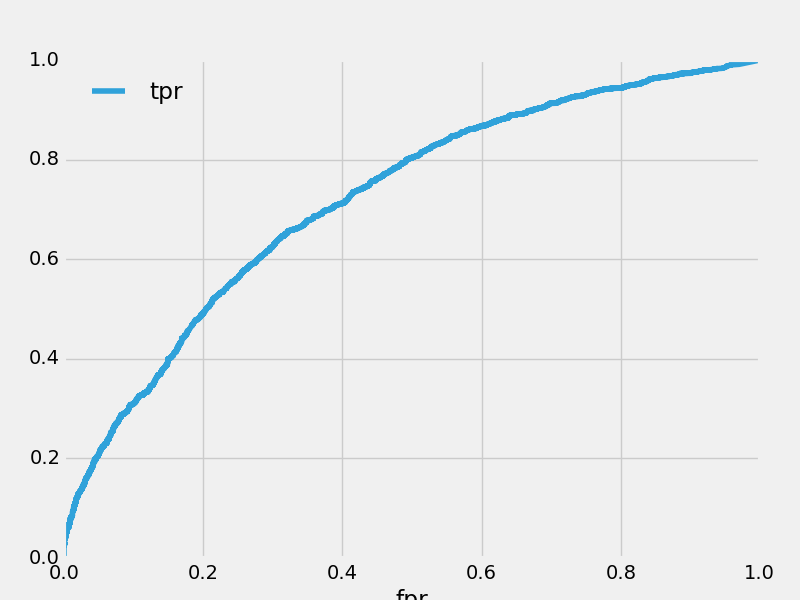

In [15]:
fig = plt.figure()
evaluate['roc_curve'].to_dataframe().sort('tpr', 0, True).plot('fpr', 'tpr')
inline_figure_on_remote(plt)

## Using Lambda workers for feature engineering

In [16]:
gl.set_runtime_config('GRAPHLAB_DEFAULT_NUM_PYLAMBDA_WORKERS', 20) # optional

### create new categorical column with lambda expression on single column

In [17]:
sf['new_1'] = sf['timedelta'].apply(lambda x: 'koza' if x > 2 else 'do_woza')

### create new array column with a function on single column

In [18]:
import array
def crete_dummy_array_column(x):
    return array.array('d', [x/4, x**2])

sf['new_2'] = sf['timedelta'].apply(crete_dummy_array_column)

### create new dict column with lambda expression on multiple columns (could be the whole sframe)

In [19]:
sf['new_3'] = sf[['num_videos', 'LDA_00', 'LDA_02']].apply(
    lambda r: {'new_3.1': r['LDA_00'] * r['num_videos'] , 'new_3.2': r['LDA_02'] * r['num_videos']})

### create new list column with function that uses external library on multiple columns

In [20]:
import pydash

def make_new_4(x):
    return pydash.chain(
        [1, 2, [3234, [41233, 5, [6, 7]]]]
    ).flatten_deep(
    ).reject(
        lambda y: y < x['timedelta']
    ).value()

sf['new_4'] = sf.apply(make_new_4)

### Let's have a look at new "features" that we created

In [21]:
new_features = ['new_{}'.format(i) for i in xrange(1,5)]

In [22]:
sf[new_features].sample(0.001).head(3)

new_1,new_2,new_3,new_4
koza,"[182.75, 534361.0]","{'new_3.1': 0.0,'new_3.2': 0.0} ...","[3234.0, 41233.0]"
koza,"[173.5, 481636.0]","{'new_3.1':0.0250081273102, ...","[3234.0, 41233.0]"
koza,"[169.5, 459684.0]","{'new_3.1':0.0286216917509, ...","[3234.0, 41233.0]"


## Graphlab classifiers can handle dict, array and string features effortlessly 

In [23]:
train, test = split_at(sf, 0.90)
random_forrest = gl.random_forest_classifier.create(train, 'is_popular', features + new_features)

WARNING: Detected extremely low variance for feature(s) 'new_1', 'new_4' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.

Random forest classifier:

--------------------------------------------------------

Number of examples          : 33968

Number of classes           : 2

Number of feature columns   : 62

Number of unpacked features : 65

+-----------+--------------+-------------------+-------------------+---------------------+---------------------+

| Iteration | Elapsed Time | Training-accuracy | Training-log_loss | Validation-accuracy | Validation-log_loss |

+-----------+--------------+-------------------+-------------------+---------------------+---------------------+

| 1         | 0.094222     | 0.648404          | 0.629732          | 0.631794            | 0.642409            |

| 2         | 0.185801     | 0.662329          | 0.621749          | 0.646990            | 0.636804            |

| 3         | 0.280343     | 0.660681          | 0.619506          | 0.633548            | 0.631687            |

| 4         | 0.372150     | 0.666186          | 0.616781          | 0.652835            | 0.627791            |

| 5         | 0.464974     | 0.666745          | 0.616516          | 0.655172            | 0.626836            |

| 6         | 0.593524     | 0.666627          | 0.616048          | 0.648743            | 0.626818            |

+-----------+--------------+-------------------+-------------------+---------------------+---------------------+

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



### Note: If your lambdas are too slow you can write them in C++ SDK and import them effortlessly in python

## 2. Data acquistion - Pulling data from the web

First we need a source of new features, what better source than the articles? We will use an awesome python library for working with news articles that will abstract away a lot of the pain of scraping, parsing and cleaning the contents of HTML pages. The library is called `newspaper` and you can install it with `pip install newspaper`.

In [24]:
# a cheap alternative for AlchemyAPI if you are just interested with cleaned data
# designed primarily for pulling data from online publishers & blogs
from newspaper import Article 

### We need a function that will download and parse the articles for each of our urls.

In [25]:
def extract(url):
    of_interest = [
        'meta_keywords',
        'text',
        'title',
        'top_image',
        'authors',
        'keywords'
    ]
    try:
        a = Article(url)
        a.download()
        a.parse()
        
        # this is a useful freebe that uses NLTK to extract keywords
        # you can comment this out if you don't want to rely on NLTK
        a.nlp()
        
    # We are working with an external site and a lot of things can go wrong
    # We want to know about it but we don't want it to mess up the execution.
    except Exception as e:
        print "Exception: {} occured at url: \t{} ".format(e, url)
        
        # We will be able to deal with the missing values later
        return {}
    
    return dict([
            # converts lists into dicts and leaves scalars untouched
            (k, v) if not isinstance(v, list) else (k, {x: 1 for x in v})
            
            # iterate over the properties of the Article object
            for k, v in vars(a).iteritems() 
            
            # keep only ones that we want
            if k in of_interest
        ])

### Let us see if it works.

In [26]:
extract("http://mashable.com/2013/01/15/tony-hawk-operation-smile")

{'authors': {u'Zoe Fox': 1},
 'keywords': {u'born': 1,
  u'children': 1,
  u'deformity': 1,
  u'facial': 1,
  u'hawk': 1,
  u'nonprofit': 1,
  u'nonprofits': 1,
  u'operation': 1,
  u'pledge': 1,
  u'share': 1,
  u'smile': 1,
  u'smiles': 1,
  u'spreads': 1,
  u'surgeries': 1,
  u'tony': 1},
 'meta_keywords': {'social-good': 1, 'uncategorized': 1, 'us-world': 1},
 'text': u"Pro skateboarder Tony Hawk has teamed up with non-profit Operation Smile to bring transformative surgery to children born with facial deformities. The campaign asks you to upload a photo of your smile and watch as it's sent across the world.\n\nThe campaign is built around an interactive film Change Forever featuring Hawk, which asks you to share your smile through a Facebook app to help children with cleft lip or cleft palate. You're then encouraged to share your smile and the film on Facebook, Twitter or Pinterest, and to take a pledge to spread awareness of facial deformities.\n\nThe pledge also states that every

### We will subsample our dataframe to make this demo faster you can remove the below if you are doing things at home and have some time

In [27]:
sf = sf.sample(0.01)

## Now we apply our extraction function (it took me 30 minutes for the whole dataset).

In [30]:
# %%time
# sf['extracted'] = sf['url'].apply(extract)
# sf.__materialize__()
# sf.save('meetml_enriched')

# CPU times: user 28.6 s, sys: 0 ns, total: 28.6 s
# Wall time: 1min 29s

sf = gl.load_sframe('meetml_enriched_with_images')

## Let's make each feature supplied by the extract method into a separate column.

In [31]:
sf = sf.unpack('extracted', column_name_prefix='')

KeyError: "column 'extracted' does not exist in current SFrame"

In [32]:
sf[['meta_keywords', 'text','title','top_image', 'authors', 'keywords']].head(3)

Columns:
	meta_keywords	dict
	text	str
	title	str
	top_image	str
	authors	dict
	keywords	dict

Rows: 3

Data:
+-------------------------------+-------------------------------+
|         meta_keywords         |              text             |
+-------------------------------+-------------------------------+
| {'winter': 1, 'watercooler... | Snow Dogs\n\nHumans often ... |
| {'2013-ces': 1, 'fitness':... | We've been tracking our Ma... |
| {'lifestyle': 1, 'ditto': ... | Jesse Draper is creator an... |
+-------------------------------+-------------------------------+
+-------------------------------+-------------------------------+
|             title             |           top_image           |
+-------------------------------+-------------------------------+
| 15 Snow Dogs That Will Mel... | http://rack.1.mshcdn.com/m... |
|  Mashable CES Challenge Day 3 | http://rack.2.mshcdn.com/m... |
| Try on Your Next Pair of G... | http://rack.1.mshcdn.com/m... |
+-------------------------------+-------------------------------+
+----------------------+-------------------------------+
|       authors        |            keywords           |
+----------------------+-------------------------------+
| {'Annie Colbert': 1} | {'heart': 1, '15': 1, 'wor... |
| {'Nora Grenfell': 1} | {'weve': 1, 'samantha': 1,... |
| {'Jesse Draper': 1}  | {'trying': 1, 'ditto': 1, ... |
+----------------------+-------------------------------+
[3 rows x 6 columns]

### We should check for how many titles we failed to download the article.

In [33]:
len(sf[sf['title'] == None]), len(sf[sf['text'] == None])

(0, 0)

## Now we will get the images!

In [34]:
def get_image(url):
    try:
        
        # Graphlab makes it pretty easy to get an image if you know its url!
        img = gl.Image(url)
        return img
    
    except Exception as e:
        print "{}: {} occured at url: \t{} ".format(type(e), e, url)  
        return None

In [35]:
# this is how you could do it at home, but we have little time so I will load cached version
# sf['image'] = sf['top_image'].apply(get_image)
# sf.__materialize__()
# sf.save('meetml_enriched_with_images')
sf = gl.load_sframe('meetml_enriched_with_images')

### We will now remove the samples that are missing either the text or image data.

In [36]:
sf = sf.dropna(['image', 'title', 'text'])

So far we did fairly standard data acquisition and munging. It was nice and simple, which is how it should be, but it did not make your inner data nerd get ecstatic. Well this is about to change. 

# 3. Deep learning for computer vision -  motivating example

In [37]:
template = "<img style='width: 900px; margin: 0px; float: left; border: 1px solid grey;' src='{img}'/>"
HTML(template.format(img='https://qph.is.quoracdn.net/main-qimg-1ffdced24c9bcd4681ef896b09d82699?convert_to_webp=true'))

#### I don't have GPUs on my server so no way I could demo training a deep learning model, but I can show you what they are used for and how you can train them yourself if you have GPUs.

##[Example usecase - photo tagging](http://phototag.herokuapp.com/)

###[You can learn how it was done](https://dato.com/learn/gallery/notebooks/build_imagenet_deeplearning.html)

### Dato gives you pretrained models so you can recreate this use case without GPU



Let's say you always marveled at the power of [deep learning](http://radar.oreilly.com/2014/07/what-is-deep-learning-and-why-should-you-care.html) but never had the means to use it. You may not have a GPU cluster at your disposal and the concept of convolution layers sounds very convoluted. With transfer learning you don't have to worry about any of this to take advantage of deep learning.

The idea of transfer learning is beautifully simple. We take an existing network, best one used for a really challenging task such as image net. We strip away the last layer that is responsible for the final classification (i.e. the one deciding weather the picture we feed it is of a dog, a cat or a chair) and use the output of the layer that precedes it. By doing this we get a dense vector of high level, abstract features of the image that we can use with any down-stream classifier, clustering algorithm or outlier detection method and it almost guarantees you will get **far** better results than with using the raw image pixels. Have I spiked your interest? You should read more this [great post on transfer learning by Piotr from Dato](http://blog.dato.com/deep-learning-blog-post).  



# 4. Transfer learning - motivating example

##[Example usecase - image similarity recommeder for fashion ecommerce](http://fresh-image.s3-website-us-west-2.amazonaws.com/)

# 5. Transfer learning, on our dataset - image similarity search

### Let's use a pre-trained model you can download from Dato repository.

In [38]:
# You can get the model for free from Dato's S3
# dl_extraction_model = gl.load_model('http://s3.amazonaws.com/GraphLab-Datasets/deeplearning/imagenet_model_iter45')
# dl_extraction_model.save('pretrained_imagenet_model')
dl_extraction_model = gl.load_model('pretrained_imagenet_model')

### We need to resize the images to the same dimensions as used with when traing the model we downloaded. Fortunately Graphlab makes it really easy.

In [39]:
sf['image'] = gl.image_analysis.resize(sf['image'], 256, 256, 3)

### Now we can use the pre-trained network to extract features from article images.

In [40]:
# %%time
# sf['image_features'] = dl_extraction_model.extract_features(sf[['image']])
# sf.save('meetml_final')
# CPU times: user 5min 12s, sys: 0 ns, total: 5min 12s
# Wall time: 3min 49s

In [41]:
sf = gl.load_sframe('meetml_final')

In [42]:
nn = gl.nearest_neighbors.create(sf, label='top_image', features=['image_features'], distance='manhattan')

Starting brute force nearest neighbors model training.

In [43]:
nn.query(sf[21:22], k=3)

Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 0            | 1       | 0.3003      | 1.652ms      |

| Done         |         | 100         | 20.519ms     |

+--------------+---------+-------------+--------------+

query_label,reference_label,distance,rank
0,http://rack.2.mshcdn.com/media/ZgkyMDEzLzAyLzI ...,0.0,1
0,http://rack.1.mshcdn.com/media/ZgkyMDEzLzA2LzE ...,1569.90339392,2
0,http://rack.0.mshcdn.com/media/ZgkyMDE0LzA5LzE ...,1625.51412633,3


In [44]:
test_image = 'http://rack.3.mshcdn.com/media/ZgkyMDEzLzEwLzA4LzRiL0JlTHV2di4zMGVkMC5qcGcKcAl0aHVtYgkxMjAweDYyNyMKZQlqcGc/91d50223/85d/BeLuvv.jpg'
template = "<p>{url}</p><img style='width: 300px; margin: 0px; float: left; border: 1px solid grey;' src='{img}'/>"
html_parts = []
for neighbor in nn.query(sf[sf['top_image'] == test_image], k=5, verbose=False):
    html_parts.append(template.format(url=neighbor['reference_label'], img=neighbor['reference_label']))
HTML("".join(html_parts))

In [45]:
template = "<p>{url}</p><img style='width: 300px; margin: 0px; float: left; border: 1px solid grey;' src='{img}'/>"
html_parts = []
for neighbor in nn.query(sf[43:44], k=5, verbose=False):
    html_parts.append(template.format(url=neighbor['reference_label'], img=neighbor['reference_label']))
HTML("".join(html_parts))

###Wow that was fast for having a stat-of-the art way of working with image data! 
####You can easily make this into a web service, but that is something for another talk. 

# 6. NLP for the lazy - word embeddings (word2vec)

## Word2Vec motivation - Dimensionality reduction

Dimensionality reduction methods try to transform (embed) a large set of features (dimensions) into a smaller set while retaining the maximum variance of the original set or preserving the distance between samples. 

##Specialized methods for text:

### 1. Topic modeling,

that treat each document as a collection of words and try to approximate a distribution of a fixed number of abstract, latent "topics" that define the likelihood of seeing certain words in a given document. For example if the topic "sport" has high value there is a high likelihood that the document will contain words like "game", "player", "win". Common methods include Latent Semantic Indexing (LSI), Latent Dirchlet Allocation (LDA) which can be "backed" by different algorithms often related to the general purpose methods, for example it is common to use truncated SVD for LSI.


###2. Word embedding,

that attempts to model each word as a dense numeric vector. Word embedding captures relationships between words - similar words have similar vectors, vectors often follow intuitive and powerful algebraic operations, such as $V(king) + V(woman) - V(man) \approx V(queen)$ and similar documents have similar average vectors. Common and hyped models include [word2vec](http://deeplearning4j.org/word2vec) and doc2vec and can be created using different algorithms. A common (but not optimal) method of dimensionality reduction for bag-of-words features is to average the vectors of each word in a given bag. 

## Enough theory! Let's go where the hype is and try to use word2vec!  
### Btw. word2vec is so 2013, you should check out sense2vec, doc2vec & paragraph2vec

To spare some time and effort we are not going to create a model from scratch but rather use a pre-trained model provided by Google. This model is created using the Google News dataset which is very appropriate to our use case. It transforms each word to a dense vector of 300 features. 

If you have only console access to the machine you are running this notebook on you can download it from my Google Drive with 

`wget https://www.googledrive.com/host/0B7XkCwpI5KDYNlNUTTlSS21pQmM`

and rename with 

`mv 0B7XkCwpI5KDYNlNUTTlSS21pQmM word2vec300.bin.gz`.

In a desktop environment just use [this link](https://www.googledrive.com/host/0B7XkCwpI5KDYNlNUTTlSS21pQmM) and rename the file manually. The model over 1.5GB so downloading it may take a while. 

Now you can use [gensim](http://radimrehurek.com/gensim/index.html) (`pip install gensim`) to load and use the word2vec model:

In [46]:
from gensim.models.word2vec import Word2Vec
word2vec = Word2Vec.load_word2vec_format('word2vec300.bin.gz', binary=True)

Loading this particular model will take up about 5.5 GB of your RAM. Make sure you have it available! 

Let us see if it works, and try to get the first 10 position of the vector representing the word "feaure":

In [47]:
word2vec['machine'][:10]

array([ 0.25585938, -0.02209473,  0.02905273,  0.05444336, -0.07421875,
        0.35351562, -0.06347656,  0.14453125,  0.07226562,  0.10009766], dtype=float32)

It works like a charm! Let's see what else we can do. **Caution!** you will need **additional 5GB** of RAM to try below examples, they are not necessary to progress with the notebook so you can skip them.

In [48]:
word2vec.similarity('dog', 'machine'), word2vec.similarity('dog', 'cat'), word2vec.similarity('dog', 'pet')

(0.10929019764586524, 0.76094570897822089, 0.71647854139756406)

In [49]:
word2vec.most_similar(positive=['woman', 'king'], negative=['man'])

[(u'queen', 0.7118191719055176),
 (u'monarch', 0.6189674139022827),
 (u'princess', 0.5902431011199951),
 (u'crown_prince', 0.5499460697174072),
 (u'prince', 0.5377321243286133),
 (u'kings', 0.5236844420433044),
 (u'Queen_Consort', 0.5235945582389832),
 (u'queens', 0.5181134343147278),
 (u'sultan', 0.5098593235015869),
 (u'monarchy', 0.5087411403656006)]

In [50]:
word2vec.doesnt_match('I eat vegtables because I am vegan and I love computers'.split())

'computers'

###What if we are even lazier? And do not want to create document vectors by hand?

Fortunately there are plenty of fish in sea of word embedding. One newcomer is `spacy` an highly optimized NLP library that supports word embedding out of the box with [GloVe](http://nlp.stanford.edu/projects/glove/) pre-trained vectors. Why not give it a try? It hase a great advantage for our usecase as it is not case sensitive and the authors of mashable like to overuse capital letters in titles. (Also it uses much less RAM)

In [51]:
from spacy.en import English
nlp = English()

In [52]:
%%time
sf['text_vec'] = [nlp(t.decode('utf-8')).vector for t in sf['text']]

CPU times: user 14 s, sys: 0 ns, total: 14 s
Wall time: 13.7 s


In [53]:
spacy_nn = gl.nearest_neighbors.create(sf, label='title', features=['text_vec'], distance='manhattan')

Starting brute force nearest neighbors model training.

In [54]:
spacy_nn.query(sf[66:67], verbose=False).print_rows(400, 400, 400)

+-------------+---------------------------------------------------------------------+----------------+------+
| query_label |                           reference_label                           |    distance    | rank |
+-------------+---------------------------------------------------------------------+----------------+------+
|      0      | Coders and Government Join Forces for National Day of Civic Hacking |      0.0       |  1   |
|      0      |       5 Social Apps To Encourage Employee Health and Wellness       | 0.826666918328 |  2   |
|      0      |              Women's Studies Programs Are Failing Women             | 0.842715526801 |  3   |
|      0      |        How J.J. Abrams Uses Entertainment to Drive Awareness        | 0.887846610373 |  4   |
|      0      |                     Everything You Need to Know                     | 0.888475138917 |  5   |
+-------------+---------------------------------------------------------------------+----------------+------+
[5 rows x 

In [55]:
spacy_nn.query(sf[43:44], verbose=False).print_rows(400, 400, 400)

+-------------+----------------------------------------------------------------+----------------+------+
| query_label |                        reference_label                         |    distance    | rank |
+-------------+----------------------------------------------------------------+----------------+------+
|      0      |                   Amazon Acquires Goodreads                    |      0.0       |  1   |
|      0      |           MashableReads is Your New Social Book Club           | 0.89965026004  |  2   |
|      0      |            A Gift to Google+ on Its Third Birthday             | 0.937591119669 |  3   |
|      0      | OpenTable Buys Foodspotting For $10 Million to Get More Social | 0.942475709933 |  4   |
|      0      |         8 Apps to Help You Get More Done in Less Time          |  1.0152302495  |  5   |
+-------------+----------------------------------------------------------------+----------------+------+
[5 rows x 4 columns]



## Thats it! Hope you enjoyed this little taste of ML!